In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import sklearn.metrics as metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
df = pd.read_csv('./kaggle_data/train.csv')
df = df[df.SalePrice < 700000] # Remove some outliers

In [3]:
# These are the manually picked columns that are all categorical
total_categorical_cols = ['MSZoning', 'Street', 'Alley', 'LandContour', 
                    'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                    'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                    'Foundation', 'Heating', 'CentralAir', 'PavedDrive',
                    'MiscFeature', 'SaleType', 'SaleCondition']

# These columns will have to be manually processed
total_rating_cols = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 
                   'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
                    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

#########
# Below will be the columns actually used in the model
#########
#category_cols = ['Neighborhood', 'SaleType', 'HouseStyle', 'LotConfig']
category_cols = ['HouseStyle', 'SaleType', 'SaleCondition']

rating_cols = ['LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
               'HeatingQC', 'Electrical', 'KitchenQual', 'Functional',
              'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

continuous_cols = ['MSSubClass', 'LotFrontage', 'OverallQual', 'OverallCond', 
                   'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 
                   'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                   'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                   'GarageYrBlt', 'GarageCars', 'PoolArea', 'MoSold', 'YrSold']

In [4]:
# Take rating columns and convert to numerical scale
rating_df = df.copy()[rating_cols]

replace_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,
               'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4,
               'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1,
               'Gtl': 1, 'Mod': 2, 'Sev': 3,
               'NA': 0,
               'Av': 3, 'Mn': 2, 'No': 1,
               'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1,
               'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1,
               'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1,
               '2Types': 6, 'Attchd': 5, 'Basment': 4, 'BuiltIn': 3, 'CarPort': 2, 'Detchd': 1,
               'Fin': 3, 'RFn': 2, 'Unf': 1,
               'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1}

rating_df.replace(replace_dict, inplace=True)

na_to_zero_cols = ['LotShape', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCond', 'GarageQual',
                   'PoolQC', 'Fence', 'Electrical']

na_to_zero_cols = [col for col in na_to_zero_cols if col in rating_df]

rating_df[na_to_zero_cols] = rating_df.loc[:, na_to_zero_cols].fillna(0)

In [5]:
# Select categorical columns and get dummy column values (different approach from what we did before with category type)
# Preferably pick columns that are not like rating columns (Bad, Okay, Great). We should handle those separately
dummy_df = pd.get_dummies(df[category_cols])

In [6]:
YVar = df[['SalePrice']]
XVar = pd.concat([df[continuous_cols], dummy_df, rating_df], axis=1)

# Filter out nan values
YVar = YVar[XVar.notna().all(axis='columns')]
XVar = XVar[XVar.notna().all(axis='columns')]

print('Num rows after filtering out nans: ' + str(len(XVar)))

XVar = XVar.apply(pd.to_numeric)

Num rows after filtering out nans: 1125


In [7]:
# Split data 80-20 so we can test how well the model works
msk = np.random.rand(len(XVar)) < 0.8

train_x = XVar[msk]
train_y = YVar[msk]

test_x = XVar[~msk]
test_y = YVar[~msk]

In [8]:
# Run linear regression with sklearn
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)

# Make predictions using the testing set, then convert to pandas series
saleprice_preds = regr.predict(test_x)
saleprice_preds = pd.Series([x for lst in saleprice_preds for x in lst])

# Print out coefficient information (coefficient of determination is perfect if it is 1)
#print('Coefficients: \n', regr.coef_)
mse = metrics.mean_squared_error(test_y, saleprice_preds) 
r2 = metrics.r2_score(test_y, saleprice_preds)

print('r2: ', round(r2,4))
print('RMSE: ', round(np.sqrt(mse),4))

r2:  0.8381
RMSE:  30906.0377


In [9]:
# Construct the results dataframe
actual_price = test_y.reset_index()['SalePrice']
pred_price = saleprice_preds.round()

res = pd.DataFrame({'actual_price': actual_price, 'predicted_price': pred_price})
res

,actual_price,predicted_price
0,307000,267164.0
1,129500,112135.0
2,159000,159353.0
3,306000,275309.0
4,207500,175619.0
...,...,...
238,140000,143114.0
239,64500,68041.0
240,120500,104428.0
241,179600,204785.0


In [10]:
res['residual'] = res.actual_price - res.predicted_price
res['percent_diff'] = (res['residual'] / res.actual_price * 100).round(decimals=2)
res

,actual_price,predicted_price,residual,percent_diff
0,307000,267164.0,39836.0,12.98
1,129500,112135.0,17365.0,13.41
2,159000,159353.0,-353.0,-0.22
3,306000,275309.0,30691.0,10.03
4,207500,175619.0,31881.0,15.36
...,...,...,...,...
238,140000,143114.0,-3114.0,-2.22
239,64500,68041.0,-3541.0,-5.49
240,120500,104428.0,16072.0,13.34
241,179600,204785.0,-25185.0,-14.02


In [11]:
print('Average percent_difference: %.2f' % (res.percent_diff.abs().mean()))

Average percent_difference: 13.12


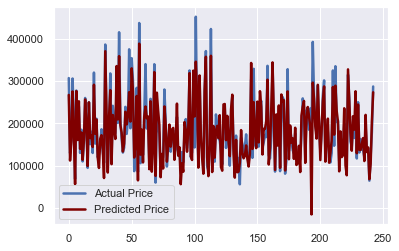

In [12]:
# Predicted price is actually really close to actual, but not when actual price is very very high
#res.plot(kind='line', y=['actual_price', 'predicted_price'])
#plt.plot(res.predicted_price, 'r--', res.actual_price)
#plt.show()

#sns.lineplot(data=res[['actual_price', 'predicted_price']])
sns_plot = sns.lineplot(data=res.actual_price, linewidth=2.5, label='Actual Price')
sns_plot = sns.lineplot(data=res.predicted_price, color='maroon', linewidth=2.5, label='Predicted Price')
sns_plot.legend()

(-200000, 300000)

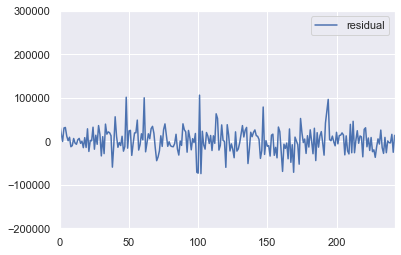

In [16]:
res2 = res[res.residual < 150000]
res2.plot(kind='line', y='residual')
plt.ylim(-200000, 300000)